In [1]:
import time
import optuna
import joblib
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, precision_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Definindo a seed para o random state
rs = 840

/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Lendo os dados
data_fraud = pd.read_csv("../data/processed/data_fraud.csv", index_col=0)

In [3]:
# Dividindo em variáveis explicativas e target
x = data_fraud.drop(["score_fraude_modelo", "fraude"], axis = 1)
y = data_fraud["fraude"]

Vamos relembrar pontos importantes que descobrimos na etapa de análise:

- As variáveis **pais** e **categoria_produto** possuem uma alta cardinalidade.
- As variáveis **pais** e **categoria_produto** possuem muitos valores com contagem de categorias iguais.
- Ainda existem variáveis com valores ausentes, tanto categóricas, como numéricas.
- O target está desbalanceado.

Sabendo disso, vamos desenhar como a etapa de experimentação irá se desenrolar:

1. Os dados serão divididos em treino, dev e teste. Iremos treinar o algoritmo
com os dados de treino, fazer a tunagem com os dados de dev, e, por fim, validar
com os dados de teste.
2. Será criado um esqueleto para o pipeline de transformação, consistindo
em um imputer e scaler(quando necessário) para as variáveis numéricas e um imputer 
e um encoder para as categóricas.
    
    2.1. Não usaremos o OneHotEncoder para as colunas com uma alta quantidade de
    categorias únicas, pois isso elevaria a dimensionalidade dos dados.

    2.2. Também não será utilizado o CountEncoder nas colunas com uma alta quantidade
    de categorias únicas, pois algumas categorias apresentam a mesma quantidade de registros.

3. A princípio, testaremos alguns modelos base com o StandardScaler (quando necessário),
OneHotEncoder para as features de baixa dimensão e CatBoostEncoder para as de alta
dimensão.
3. As métricas avaliadas serão o Recall e a Latência média.
4. Os modelos mais promissores entrarão em outra rodada de experimentos, dessa
vez para testar outras combinações de encoders e scalers (se necessário).

Agora que sabemos o que fazer, vamos descobrir quais métricas devemos superar.
Para tal, vamos calcular o **recall** e **f1_weighted** das predições do modelo atual, 
assim como ganhos e perdas que tais predições geram. Segue como cada uma será
calculada:

- Perdas: o valor de compra de todos os falsos negativos (fraudes identificadas como compras legítimas) serão somadas.
- Lucro Bruto: o valor de todos os verdadeiros negativos (compras legítimas não identificadas como fraude).
- Lucro líquido: Lucro Bruto - Perdas

Eu também poderia acrescentar os falsos positivos (compras legítimas 
identificadas como fraudulentas), mas como não sei se a compra é cancelada de
vez ou aguarda confirmação adicional por parte do cliente, optarei por não
incluir esses valores.

As métricas serão calculadas a partir dos dados de **teste**.


In [4]:
# Define o local para salvar os exoerimentos
mlflow.set_tracking_uri('../mlruns')

In [5]:
# Divindo os dados em treino, dev e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x,
                                                        y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=rs)

x_dev, x_teste, y_dev, y_teste = train_test_split(x_teste, 
                                                  y_teste,
                                                  stratify=y_teste,
                                                  test_size=0.5,
                                                  random_state=rs)

# Dividindo features numéricas de categóricas
cat_cols_high_dim = ["pais", "categoria_produto"]
cat_cols = [col for col in x_treino.select_dtypes("object").columns if col not in cat_cols_high_dim]
num_cols = x_treino.select_dtypes(["int", "float"]).columns

# Setando o KFold
kf = StratifiedKFold(shuffle=True, random_state=rs)

In [6]:
# Obtendo os dados de métricas
data_metrics = data_fraud.loc[y_teste.index, ["valor_compra", "score_fraude_modelo", "fraude"]]

# Criando uma label com base nos scores do modelo
data_metrics["label_fraude_modelo"] = data_metrics["score_fraude_modelo"].apply(lambda score: 1 if score >= 50 else 0)

# Reduzindo o score para a escala entre 0 e 1
data_metrics["score_fraude_modelo"] = data_metrics["score_fraude_modelo"]/100

In [7]:
data_metrics.head()

,valor_compra,score_fraude_modelo,fraude,label_fraude_modelo
111828,6.39,0.87,0,1
53621,10.41,0.90,0,1
29541,9.98,0.19,0,0
122478,14.10,0.56,0,1
73542,479.30,0.86,0,1


In [8]:
# Calculando as métricas
recall = recall_score(data_metrics["fraude"], data_metrics["label_fraude_modelo"])
f1_weighted = f1_score(data_metrics["fraude"], data_metrics["label_fraude_modelo"], average="weighted")
perdas = data_metrics.query("fraude == 1 and label_fraude_modelo == 0")["valor_compra"].sum()
ganhos_brutos = (data_metrics.query("fraude == 0 and label_fraude_modelo == 0")["valor_compra"] * 0.10).sum()
ganhos_liquidos = ganhos_brutos - perdas

print("Com o threshold base (50%), o recall é de: ", recall)
print("Com o threshold base (50%), o f1-score weighted é de: ", f1_weighted)
print("Com o threshold base (50%), as perdas são de: ", perdas)
print("Com o threshold base (50%), os ganhos bruto são de: ", ganhos_brutos)
print("Com o threshold base (50%), os ganhos líquidos são de: ", ganhos_liquidos)

Com o threshold base (50%), o recall é de:  0.7608888888888888
Com o threshold base (50%), o f1-score weighted é de:  0.6586582569846577
Com o threshold base (50%), as perdas são de:  12690.34
Com o threshold base (50%), os ganhos bruto são de:  42153.344000000005
Com o threshold base (50%), os ganhos líquidos são de:  29463.004000000004


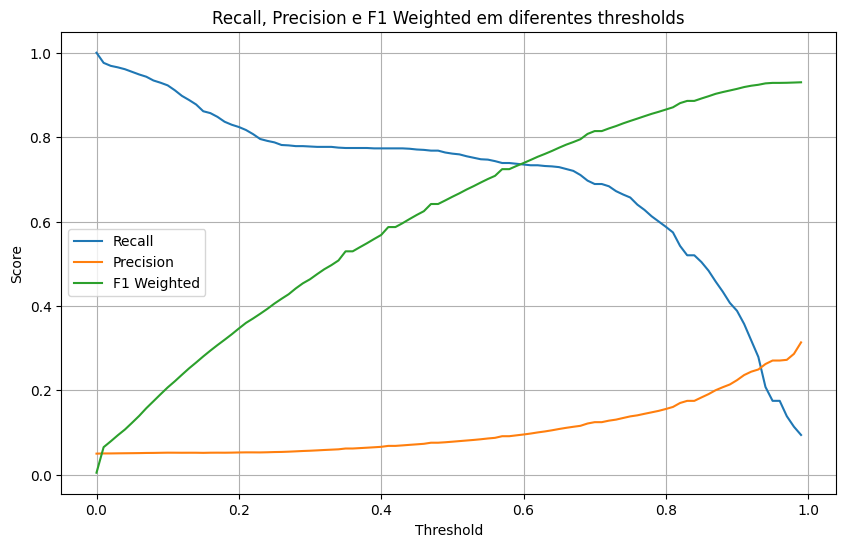

In [9]:
data_dict = {"Threshold":[], 
             "Recall":[],
             "Precision":[],
             "F1 Weighted":[],
             "Ganhos Brutos":[],
             "Perdas":[],
             "Ganhos Líquidos":[]}

# Calculando as métricas para cada threshold
for threshold in np.arange(0, 1, 0.01):
    predictions = (data_metrics["score_fraude_modelo"] >= threshold).astype(int)
    recall = recall_score(y_teste, predictions)
    precision = precision_score(y_teste, predictions)
    f1 = f1_score(y_teste, predictions, average="weighted")
    data_dict["Threshold"].append(threshold)
    data_dict["Recall"].append(recall)
    data_dict["Precision"].append(precision)
    data_dict["F1 Weighted"].append(f1)
    
    data_metrics["label_fraude_modelo"] = predictions
    acertos = data_metrics.query(f"fraude == 0 and label_fraude_modelo == 0")
    erros = data_metrics.query(f"fraude == 1 and label_fraude_modelo == 0")
    ganhos = (acertos["valor_compra"] * 0.10).sum()
    perdas = erros["valor_compra"].sum()
    diff_ganhos_perdas = ganhos - perdas
    data_dict["Ganhos Brutos"].append(ganhos)
    data_dict["Perdas"].append(perdas)
    data_dict["Ganhos Líquidos"].append(diff_ganhos_perdas)
        
# Plotando o gráfico    
plt.figure(figsize=(10, 6))
sns.lineplot(x=data_dict["Threshold"], y=data_dict["Recall"], label='Recall')
sns.lineplot(x=data_dict["Threshold"], y=data_dict["Precision"], label='Precision')
sns.lineplot(x=data_dict["Threshold"], y=data_dict["F1 Weighted"], label='F1 Weighted')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision e F1 Weighted em diferentes thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Visualizando os dados em forma de tabela
pd.DataFrame(data_dict).sort_values(by="Ganhos Líquidos", ascending=False)

,Threshold,Recall,Precision,F1 Weighted,Ganhos Brutos,Perdas,Ganhos Líquidos
76,0.76,0.640000,0.140762,0.843891,65912.190,19549.98,46362.210
75,0.75,0.656889,0.138260,0.838339,64916.138,18666.09,46250.048
77,0.77,0.627556,0.144376,0.849570,66744.637,20611.54,46133.097
80,0.80,0.587556,0.155786,0.865329,70014.224,23907.04,46107.184
79,0.79,0.600000,0.151379,0.860041,68921.392,22849.33,46072.062
...,...,...,...,...,...,...,...
4,0.04,0.960889,0.050904,0.107224,4596.165,2524.54,2071.625
3,0.03,0.965333,0.050722,0.093628,3830.730,2447.83,1382.900
2,0.02,0.968889,0.050479,0.079154,3133.909,2094.57,1039.339
1,0.01,0.976000,0.050439,0.065304,2313.644,1486.31,827.334


O nosso maior ganho está no Threshold 0.76, onde o lucro líquido foi de 46362.21

## Realizando os experimentos

In [11]:
# Definindo os dicionarios com os modelos e etapas de pre-processamento que serã utilizadas

dict_models_scale_sensitive = {"LR": LogisticRegression(random_state=rs,
                                                        class_weight='balanced')}

dict_models_tree_based = {"LGBM": LGBMClassifier(is_unbalance=True,
                                                 objective= 'binary',
                                                 random_state=rs),
                          "XGB": XGBClassifier(random_state=rs,
                                               objective='binary:hinge'),
                          "RF": RandomForestClassifier(class_weight='balanced',
                                                       random_state=rs)}

# Criando dicionário com os encoders
dict_encoders = {"OHE": OneHotEncoder(drop='first'),
                 "TE": ce.TargetEncoder(),
                 "BE": ce.BinaryEncoder(),
                 "ME": ce.MEstimateEncoder(),
                 "CE": ce.CatBoostEncoder(),
                 "GE":ce.GrayEncoder(),
                 "CTE":ce.CountEncoder()}

dict_imputers_num = {"SIAVG": SimpleImputer(strategy='mean'),
                     "SIMEDIAN": SimpleImputer(strategy='median')}

dict_scalers = {"SS": StandardScaler(),
                "RS": RobustScaler()}

# Criando dicionário com os transformers
dict_transformers = {"PT": PowerTransformer()}

In [12]:
# Criando/acessando o experimento
mlflow.set_experiment('Comparando modelos base')
#
## Iniciando os experimentos sem transformers
#for tag, model in dict_models_scale_sensitive.items():
#
#    # Gerando a tag de identificação do modelo
#    nome_modelo = f'{tag}'
#
#    with mlflow.start_run(run_name=nome_modelo):
#
#        # Criando os pipeline com os transformers
#        pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                            ('encoder', OneHotEncoder(drop='first'))])
#    
#        # Criando os pipeline com os transformers
#        pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                        ('encoder_hd', ce.CatBoostEncoder())])
#    
#        pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
#                            ('scaler', StandardScaler())])
#    
#        # Criando o transformador
#        transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                        ('num', pipe_num, num_cols),
#                                        ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                        remainder="passthrough")
#    
#        # Criando o pipeline final
#        pipe = Pipeline([('transformer', transformer),
#                        ('model', model)])
#    
#        # Executando o cross validation
#        cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#    
#        # Calculando a média das métricas
#        mean_score = cross_val_scores.mean()           
#    
#        # Salvando a métrica da folder 1
#        mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#    
#        # Salvando a métrica da folder 2
#        mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#    
#        # Salvando a métrica da folder 3
#        mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#    
#        # Salvando a métrica da folder 4
#        mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#    
#        # Salvando a métrica da folder 5
#        mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#    
#        # Salvando as métricas
#        mlflow.log_metric('recall_mean', mean_score)
#        
#        # Salvando o f1 weighted
#        mean_f1 = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='f1_weighted').mean()
#        
#        # Salvando a métrica do f1
#        mlflow.log_metric('f1_weighted_mean', mean_f1)
#    
#        # Treinando o algoritmo
#        pipe.fit(x_treino, y_treino)
#    
#        # Calculando a latência média
#        latency_list = []
#    
#        for _, row in x_treino[:1000].iterrows():
#        
#            # Início da contagem de tempo
#            start_time = time.time()
#    
#            # Extrair os recursos da linha
#            features = row.values.reshape(1, -1)
#    
#            # Fazer a previsão para a linha individual
#            prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#    
#            # Encerra a contagem
#            end_time = time.time()
#            atomic_time = end_time - start_time
#    
#            # Transforma segundo em milissegundo
#            atomic_milissec = atomic_time * 1000
#    
#            # Adiciona o tempo em uma lista
#            latency_list.append(atomic_milissec)
#    
#        # calcula a média 
#        mlflow.log_metric("Latência média", np.mean(latency_list))

<Experiment: artifact_location='/home/daniel/Documents/preditor_fraude/notebooks/../mlruns/625986320513183998', creation_time=1712879630375, experiment_id='625986320513183998', last_update_time=1712879630375, lifecycle_stage='active', name='Comparando modelos base', tags={}>

In [13]:
## Iniciando os experimentos sem transformers
#for tag, model in dict_models_tree_based.items():
#
#    # Gerando a tag de identificação do modelo
#    nome_modelo = f'{tag}'
#
#    with mlflow.start_run(run_name=nome_modelo):
#
#        # Criando os pipeline com os transformers
#        pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                            ('encoder', OneHotEncoder(drop='first'))])
#    
#        # Criando os pipeline com os transformers
#        pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                        ('encoder_hd', ce.CatBoostEncoder())])
#    
#        pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median"))])
#    
#        # Criando o transformador
#        transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                        ('num', pipe_num, num_cols),
#                                        ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                        remainder="passthrough")
#    
#        # Criando o pipeline final
#        pipe = Pipeline([('transformer', transformer),
#                        ('model', model)])
#    
#        # Executando o cross validation
#        cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#    
#        # Calculando a média das métricas
#        mean_score = cross_val_scores.mean()           
#    
#        # Salvando a métrica da folder 1
#        mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#    
#        # Salvando a métrica da folder 2
#        mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#    
#        # Salvando a métrica da folder 3
#        mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#    
#        # Salvando a métrica da folder 4
#        mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#    
#        # Salvando a métrica da folder 5
#        mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#    
#        # Salvando as métricas
#        mlflow.log_metric('recall_mean', mean_score)
#        
#        # Salvando o f1 weighted
#        mean_f1 = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='f1_weighted').mean()
#        
#        # Salvando a métrica do f1
#        mlflow.log_metric('f1_weighted_mean', mean_f1)
#    
#        # Treinando o algoritmo
#        pipe.fit(x_treino, y_treino)
#    
#        # Calculando a latência média
#        latency_list = []
#    
#        for _, row in x_treino[:1000].iterrows():
#        
#            # Início da contagem de tempo
#            start_time = time.time()
#    
#            # Extrair os recursos da linha
#            features = row.values.reshape(1, -1)
#    
#            # Fazer a previsão para a linha individual
#            prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#    
#            # Encerra a contagem
#            end_time = time.time()
#            atomic_time = end_time - start_time
#    
#            # Transforma segundo em milissegundo
#            atomic_milissec = atomic_time * 1000
#    
#            # Adiciona o tempo em uma lista
#            latency_list.append(atomic_milissec)
#    
#        # calcula a média 
#        mlflow.log_metric("Latência média", np.mean(latency_list))

In [14]:
# Definindo as colunas de interesse
colunas_para_buscar = ["tags.mlflow.runName", 'metrics.f1_weighted_mean', 
                       'metrics.recall_mean', 'metrics.Latência média', 
                       'metrics.recall_fold_1', 'metrics.recall_fold_2', 
                       'metrics.recall_fold_3', 'metrics.recall_fold_4', 
                       'metrics.recall_fold_5']

# Buscando os melhores modelos
runs = mlflow.search_runs()[colunas_para_buscar]

# Ordenando por recall médio
runs.sort_values(by="metrics.recall_mean", ascending=False)

,tags.mlflow.runName,metrics.f1_weighted_mean,metrics.recall_mean,metrics.Latência média,metrics.recall_fold_1,metrics.recall_fold_2,metrics.recall_fold_3,metrics.recall_fold_4,metrics.recall_fold_5
3,LR,0.808796,0.672000,22.539703,0.661905,0.676190,0.671429,0.662857,0.687619
2,LGBM,0.839467,0.636000,41.101751,0.631429,0.629524,0.642857,0.629524,0.646667
1,XGB,0.934448,0.108571,62.942002,0.110476,0.101905,0.110476,0.093333,0.126667
0,RF,0.932240,0.058095,28.739755,0.064762,0.047619,0.062857,0.059048,0.056190


Dos modelos testados, apenas o **LightGBM** e a **Regressão Logística** tiveram
um bom resultado. 

- O **Recall** do **LightGBM** é cerca de **0.5% superior** ao da **Regressão**.
- A **latência** do **LightGBM** é cerca de **76% maior** do que a da **Regressão**.

Vamos tunar e avaliar ambos os modelos.

In [15]:
# Criando/acessando o experimento
mlflow.set_experiment('Comparando regressões')

## Iniciando os experimentos com regressões
#for tag_encoder, encoder in dict_encoders.items():
#    for tag_scaler, scaler in dict_scalers.items():
#        for tag_imputer, imputer in dict_imputers_num.items():
#        
#            # Gerando a tag de identificação do modelo
#            nome_modelo = f'LR_{tag_encoder}_{tag_scaler}_{tag_imputer}'
#
#            with mlflow.start_run(run_name=nome_modelo):
#            
#                # Criando os pipeline com os transformers
#                pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                    ('encoder', encoder)])
#
#                # Criando os pipeline com os transformers
#                pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                                ('encoder_hd', ce.CatBoostEncoder())])
#
#                pipe_num = Pipeline([('imputer_num', imputer),
#                                     ('scaler', scaler)])
#
#                # Criando o transformador
#                transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                                ('num', pipe_num, num_cols),
#                                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                                remainder="passthrough")
#
#                # Criando o pipeline final
#                pipe = Pipeline([('transformer', transformer),
#                                ('model', LogisticRegression(class_weight='balanced',
#                                                             random_state=rs))])
#
#                # Executando o cross validation
#                cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#
#                # Calculando a média das métricas
#                mean_score = cross_val_scores.mean()           
#
#                # Salvando a métrica da folder 1
#                mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#
#                # Salvando a métrica da folder 2
#                mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#
#                # Salvando a métrica da folder 3
#                mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#
#                # Salvando a métrica da folder 4
#                mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#
#                # Salvando a métrica da folder 5
#                mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#
#                # Salvando as métricas
#                mlflow.log_metric('recall_mean', mean_score)
#                
#                # Salvando o f1 weighted
#                mean_f1 = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='f1_weighted').mean()
#                
#                # Salvando a métrica do f1
#                mlflow.log_metric('f1_weighted_mean', mean_f1)
#
#                # Treinando o algoritmo
#                pipe.fit(x_treino, y_treino)
#
#                # Calculando a latência média
#                latency_list = []
#
#                for _, row in x_treino[:1000].iterrows():
#                
#                    # Início da contagem de tempo
#                    start_time = time.time()
#
#                    # Extrair os recursos da linha
#                    features = row.values.reshape(1, -1)
#
#                    # Fazer a previsão para a linha individual
#                    prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#
#                    # Encerra a contagem
#                    end_time = time.time()
#                    atomic_time = end_time - start_time
#
#                    # Transforma segundo em milissegundo
#                    atomic_milissec = atomic_time * 1000
#
#                    # Adiciona o tempo em uma lista
#                    latency_list.append(atomic_milissec)
#
#                # calcula a média 
#                mlflow.log_metric("Latência média", np.mean(latency_list))
#

<Experiment: artifact_location='/home/daniel/Documents/preditor_fraude/notebooks/../mlruns/487365208729813759', creation_time=1712925073654, experiment_id='487365208729813759', last_update_time=1712925073654, lifecycle_stage='active', name='Comparando regressões', tags={}>

In [16]:
# Definindo as colunas de interesse
colunas_para_buscar = ["tags.mlflow.runName", 'metrics.f1_weighted_mean', 
                       'metrics.recall_mean', 'metrics.Latência média', 
                       'metrics.recall_fold_1', 'metrics.recall_fold_2', 
                       'metrics.recall_fold_3', 'metrics.recall_fold_4', 
                       'metrics.recall_fold_5']

# Buscando os melhores modelos
runs = mlflow.search_runs()[colunas_para_buscar]

# Ordenando por recall médio
runs.sort_values(by="metrics.recall_mean", ascending=False)

,tags.mlflow.runName,metrics.f1_weighted_mean,metrics.recall_mean,metrics.Latência média,metrics.recall_fold_1,metrics.recall_fold_2,metrics.recall_fold_3,metrics.recall_fold_4,metrics.recall_fold_5
0,LR_CTE_RS_SIMEDIAN,0.690758,0.700571,39.934036,0.721905,0.708571,0.682857,0.685714,0.703810
1,LR_CTE_RS_SIAVG,0.717180,0.699048,45.698645,0.714286,0.706667,0.680952,0.685714,0.707619
7,LR_GE_SS_SIAVG,0.807978,0.673333,51.978545,0.661905,0.677143,0.673333,0.665714,0.688571
17,LR_BE_RS_SIAVG,0.808237,0.673333,56.522726,0.661905,0.678095,0.665714,0.670476,0.690476
18,LR_BE_SS_SIMEDIAN,0.808429,0.672762,56.829186,0.660000,0.673333,0.678095,0.663810,0.688571
24,LR_OHE_RS_SIMEDIAN,0.806843,0.672762,30.154952,0.662857,0.674286,0.674286,0.664762,0.687619
6,LR_GE_SS_SIMEDIAN,0.808443,0.672381,60.197710,0.660952,0.677143,0.669524,0.661905,0.692381
4,LR_GE_RS_SIMEDIAN,0.807141,0.672381,63.011021,0.658095,0.677143,0.669524,0.665714,0.691429
25,LR_OHE_RS_SIAVG,0.806142,0.672190,20.303402,0.656190,0.674286,0.673333,0.665714,0.691429
26,LR_OHE_SS_SIMEDIAN,0.808796,0.672000,25.794318,0.661905,0.676190,0.671429,0.662857,0.687619


In [17]:
# Criando/acessando o experimento
mlflow.set_experiment('Comparando lgbms')

## Iniciando os experimentos com o lightgbm
#for tag_encoder, encoder in dict_encoders.items():
#        for tag_imputer, imputer in dict_imputers_num.items():
#    
#            # Gerando a tag de identificação do modelo
#            nome_modelo = f'LGBM_{tag_encoder}_{tag_imputer}'
#    
#            with mlflow.start_run(run_name=nome_modelo):
#            
#                # Criando os pipeline com os transformers
#                pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                    ('encoder', encoder)])
#    
#                # Criando os pipeline com os transformers
#                pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                                ('encoder_hd', ce.CatBoostEncoder())])
#    
#                pipe_num = Pipeline([('imputer_num', imputer)])
#    
#                # Criando o transformador
#                transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                                ('num', pipe_num, num_cols),
#                                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                                remainder="passthrough")
#    
#                # Criando o pipeline final
#                pipe = Pipeline([('transformer', transformer),
#                                ('model', LGBMClassifier(is_unbalance=True,
#                                                 objective= 'binary',
#                                                 random_state=rs))])
#    
#                # Executando o cross validation
#                cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#    
#                # Calculando a média das métricas
#                mean_score = cross_val_scores.mean()           
#    
#                # Salvando a métrica da folder 1
#                mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#    
#                # Salvando a métrica da folder 2
#                mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#    
#                # Salvando a métrica da folder 3
#                mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#    
#                # Salvando a métrica da folder 4
#                mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#    
#                # Salvando a métrica da folder 5
#                mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#    
#                # Salvando as métricas
#                mlflow.log_metric('recall_mean', mean_score)
#                
#                # Salvando o f1 weighted
#                mean_f1 = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='f1_weighted').mean()
#                
#                # Salvando a métrica do f1
#                mlflow.log_metric('f1_weighted_mean', mean_f1)
#    
#                # Treinando o algoritmo
#                pipe.fit(x_treino, y_treino)
#    
#                # Calculando a latência média
#                latency_list = []
#    
#                for _, row in x_treino[:1000].iterrows():
#                
#                    # Início da contagem de tempo
#                    start_time = time.time()
#    
#                    # Extrair os recursos da linha
#                    features = row.values.reshape(1, -1)
#    
#                    # Fazer a previsão para a linha individual
#                    prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#    
#                    # Encerra a contagem
#                    end_time = time.time()
#                    atomic_time = end_time - start_time
#    
#                    # Transforma segundo em milissegundo
#                    atomic_milissec = atomic_time * 1000
#    
#                    # Adiciona o tempo em uma lista
#                    latency_list.append(atomic_milissec)
#    
#                # calcula a média 
#                mlflow.log_metric("Latência média", np.mean(latency_list))
#    

<Experiment: artifact_location='/home/daniel/Documents/preditor_fraude/notebooks/../mlruns/266755400377406776', creation_time=1712927647360, experiment_id='266755400377406776', last_update_time=1712927647360, lifecycle_stage='active', name='Comparando lgbms', tags={}>

In [18]:
# Definindo as colunas de interesse
colunas_para_buscar = ["tags.mlflow.runName", 'metrics.f1_weighted_mean', 
                       'metrics.recall_mean', 'metrics.Latência média', 
                       'metrics.recall_fold_1', 'metrics.recall_fold_2', 
                       'metrics.recall_fold_3', 'metrics.recall_fold_4', 
                       'metrics.recall_fold_5']

# Buscando os melhores modelos
runs = mlflow.search_runs()[colunas_para_buscar]

# Ordenando por recall médio
runs.sort_values(by="metrics.recall_mean", ascending=False)

,tags.mlflow.runName,metrics.f1_weighted_mean,metrics.recall_mean,metrics.Latência média,metrics.recall_fold_1,metrics.recall_fold_2,metrics.recall_fold_3,metrics.recall_fold_4,metrics.recall_fold_5
11,LGBM_TE_SIAVG,0.838867,0.643619,62.969607,0.640000,0.642857,0.651429,0.636190,0.647619
7,LGBM_ME_SIAVG,0.838867,0.643619,56.503378,0.640000,0.642857,0.651429,0.636190,0.647619
13,LGBM_OHE_SIAVG,0.837828,0.639619,39.661925,0.632381,0.628571,0.656190,0.639048,0.641905
4,LGBM_CE_SIMEDIAN,0.839450,0.639429,68.224117,0.647619,0.610476,0.660000,0.634286,0.644762
3,LGBM_GE_SIAVG,0.837333,0.639429,64.073688,0.638095,0.629524,0.650476,0.632381,0.646667
2,LGBM_GE_SIMEDIAN,0.839062,0.638667,64.845442,0.632381,0.628571,0.649524,0.632381,0.650476
9,LGBM_BE_SIAVG,0.838539,0.638095,66.973334,0.637143,0.627619,0.642857,0.641905,0.640952
10,LGBM_TE_SIMEDIAN,0.838495,0.636952,61.431783,0.640952,0.623810,0.649524,0.632381,0.638095
6,LGBM_ME_SIMEDIAN,0.838495,0.636952,58.542917,0.640952,0.623810,0.649524,0.632381,0.638095
8,LGBM_BE_SIMEDIAN,0.838933,0.636000,65.299150,0.636190,0.629524,0.632381,0.634286,0.647619


#### Regressão Logística 
A combinação **Logistic Regression** + **CountEncoder** + **RobustSaler** + 
**SimpleImputer(Mediana)** obteve o primeiro lugar com as seguintes estatísticas:
- Recall médio de 0.70
- F1 weighted médio de 0.69 
- Latência média de 39 milissegundos

No geral, são boas métricas, e ele será o modelo escolhido. Entretanto, também
houveram outras combinações que se saíram bem. A combinação 
**Logistic Regression** + **OneHotEncoder** + **RobustSaler** + 
**SimpleImputer(Media)** demonstrou ser promissora:
- Recall médio de 0.67 (0.03 a menos que o primeiro colocado)
- F1 weighted médio de 0.80 (0.10 a mais que o primeiro colocado)
- Latência média de 20 milissegundos (19 milissegundos a menos que o primeiro colocado)

Selecionaremos esses dois modelos para tunar os parâmetros.

#### LightGBM

Para os modelos com base no LightGBM, temos métricas bem semelhantes entre as 
combinações, por isso, selecionaremos aquele com a menor latência dentre os 
5 primeiros:
**LightGBM** + **OneHotEncoder** + **SimpleImputer(Média)**

## Tunando o modelo candidato

Agora que já temos a melhor combinação de preprocessors, vamos buscar a melhor
opção de hiperparâmetros.

Para tal, usaremos o **Optuna**.

Vamos iniciar com a primeira regressão: **Logistic Regression** + **CountEncoder** + **RobustSaler** + 
**SimpleImputer(Mediana)**.

In [19]:
## Criando função para tunar o modelo
#def objective(trial):
#
#    params = {
#        'C': trial.suggest_float('C', 1e-4, 1e+4, log=True),
#        'penalty': trial.suggest_categorical('penalty', [None, 'l2']),
#        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga', 'newton-cholesky']),
#        'max_iter': trial.suggest_int('max_iter', 50, 1000),
#        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
#        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
#        'random_state': rs
#    }
#    
#    # Criando os pipeline com os transformers
#    pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                        ('encoder', ce.CountEncoder())])
#
#    # Criando os pipeline com os transformers
#    pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                    ('encoder_hd', ce.CatBoostEncoder())])
#
#    pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
#                          ("scaler", RobustScaler())])
#
#    # Criando o transformador
#    transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                    ('num', pipe_num, num_cols),
#                                    ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                    remainder="passthrough")
#    
#    # Criando o pipeline final
#    pipe = Pipeline([('transformer', transformer),
#                    ('model', LogisticRegression(**params))])
#
#    # Treinando o modelo com os dados de treino
#    pipe.fit(x_treino, y_treino)
#   
#    recall = recall_score(y_dev, pipe.predict(x_dev))
#    
#    return recall
#
## Criando o estudo de otimização
#study = optuna.create_study(direction = 'maximize')
#study.optimize(objective, n_trials = 50)


Obtivemos parâmetros que quase zeram a taxa de falsos negativos. Averiguaremos 
melhor durante o teste final, mas me reservarei a selecionar outro conjunto de 
parâmetros que identifiquei no log dos experimentos, pois diferentemente dos
melhores parâmetros encontrados, estes usam regularização, que ajuda a prevenir o 
overfitting. 

In [20]:
# salvando os melhores parâmetros
best_params_l1_v1 = {'C': 0.0003497693165590731,
                    'penalty': None,
                    'solver': 'saga',
                    'max_iter': 224,
                    'fit_intercept': False,
                    'class_weight': 'balanced',
                    'random_state': rs}

best_params_l1_v2 = {'C': 1789.4428651327607, 
                      'penalty': 'l2', 
                      'solver': 'saga', 
                      'max_iter': 694, 
                      'fit_intercept': True, 
                      'class_weight': 'balanced',
                      'random_state':rs}

In [21]:
# Criando os pipeline com os transformers
pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                    ('encoder', ce.CountEncoder())])

# Criando os pipeline com os transformers
pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                                ('encoder_hd', ce.CatBoostEncoder())])

pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
                        ("scaler", RobustScaler())])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('num', pipe_num, num_cols),
                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
                                remainder="passthrough")

# Criando o pipeline final
pipe_logistica_1_v1 = Pipeline([('transformer', transformer),
                ('model', LogisticRegression(**best_params_l1_v1))])

# Treinando o modelo com os dados de treino
pipe_logistica_1_v1.fit(x_treino, y_treino)

/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   CountEncoder(combine_min_nan_groups=True))]),
                                                  ['entrega_doc_2',
                                                   'entrega_doc_3',
                                                   'continente',
                                                   'nome_dia_compra',
                                                   'dia_compra_classe',
                                                   'turno_compra',
                                                   'horario_comercial_compra']),...
       'valor_compra', 'dia_compra', 'hora_compra'],
      dtype='object')),
                                                 ('cat_hd',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder_hd',
                                                                   CatBoostEncoder())]),
                                                  ['pais',
                                                   'categoria_produto'])])),
                ('model',
                 LogisticRegression(C=0.0003497693165590731,
                                    class_weight='balanced',
                                    fit_intercept=False, max_iter=224,
                                    penalty=None, random_state=840,
                                    solver='saga'))])

In [22]:
# Criando os pipeline com os transformers
pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                    ('encoder', ce.CountEncoder())])

# Criando os pipeline com os transformers
pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                                ('encoder_hd', ce.CatBoostEncoder())])

pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
                        ("scaler", RobustScaler())])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('num', pipe_num, num_cols),
                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
                                remainder="passthrough")

# Criando o pipeline final
pipe_logistica_1_v2 = Pipeline([('transformer', transformer),
                ('model', LogisticRegression(**best_params_l1_v2))])

# Treinando o modelo com os dados de treino
pipe_logistica_1_v2.fit(x_treino, y_treino)

/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   CountEncoder(combine_min_nan_groups=True))]),
                                                  ['entrega_doc_2',
                                                   'entrega_doc_3',
                                                   'continente',
                                                   'nome_dia_compra',
                                                   'dia_compra_classe',
                                                   'turno_compra',
                                                   'horario_comercial_compra']),...
       'score_7', 'score_8', 'score_9', 'score_10', 'entrega_doc_1',
       'valor_compra', 'dia_compra', 'hora_compra'],
      dtype='object')),
                                                 ('cat_hd',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder_hd',
                                                                   CatBoostEncoder())]),
                                                  ['pais',
                                                   'categoria_produto'])])),
                ('model',
                 LogisticRegression(C=1789.4428651327607,
                                    class_weight='balanced', max_iter=694,
                                    random_state=840, solver='saga'))])

Agora, vamos testar a segunda: **Logistic Regression** + **OneHotEncoder** + **RobustSaler** + 
**SimpleImputer(Media)**.

In [23]:
## Criando função para tunar o modelo
#def objective(trial):
#
#    params = {
#        'C': trial.suggest_float('C', 1e-4, 1e+4, log=True),
#        'penalty': trial.suggest_categorical('penalty', [None, 'l2']),
#        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga', 'newton-cholesky']),
#        'max_iter': trial.suggest_int('max_iter', 50, 1000),
#        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
#        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
#        'random_state': rs
#    }
#    
#    # Criando os pipeline com os transformers
#    pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                        ('encoder', OneHotEncoder(drop='first'))])
#
#    # Criando os pipeline com os transformers
#    pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                    ('encoder_hd', ce.CatBoostEncoder())])
#
#    pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="mean")),
#                        ('scaler', RobustScaler())])
#
#    # Criando o transformador
#    transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                    ('num', pipe_num, num_cols),
#                                    ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                    remainder="passthrough")
#    
#    # Criando o pipeline final
#    pipe = Pipeline([('transformer', transformer),
#                    ('model', LogisticRegression(**params))])
#
#    # Treinando o modelo com os dados de treino
#    pipe.fit(x_treino, y_treino)
#   
#    recall = recall_score(y_dev, pipe.predict(x_dev))
#    
#    return recall
#
## Criando o estudo de otimização
#study = optuna.create_study(direction = 'maximize')
#study.optimize(objective, n_trials = 50)
#

In [24]:
best_params_l2 = {'C': 3.9049332827863656,
                    'penalty': None,
                    'solver': 'saga',
                    'max_iter': 983,
                    'fit_intercept': True,
                    'class_weight': 'balanced',
                    'random_state':rs}

In [25]:
# Criando os pipeline com os transformers
pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                    ('encoder', OneHotEncoder(drop='first'))])

# Criando os pipeline com os transformers
pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                                ('encoder_hd', ce.CatBoostEncoder())])

pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="mean")),
                    ('scaler', RobustScaler())])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('num', pipe_num, num_cols),
                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
                                remainder="passthrough")

# Criando o pipeline final
pipe_logistica_2 = Pipeline([('transformer', transformer),
                ('model', LogisticRegression(**best_params_l2))])

# Treinando o modelo com os dados de treino
pipe_logistica_2.fit(x_treino, y_treino)

/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['entrega_doc_2',
                                                   'entrega_doc_3',
                                                   'continente',
                                                   'nome_dia_compra',
                                                   'dia_compra_classe',
                                                   'turno_compra',
                                                   'horario_comercial_compra']),
                                                 ('num',
                                                  Pipelin...
       'score_7', 'score_8', 'score_9', 'score_10', 'entrega_doc_1',
       'valor_compra', 'dia_compra', 'hora_compra'],
      dtype='object')),
                                                 ('cat_hd',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder_hd',
                                                                   CatBoostEncoder())]),
                                                  ['pais',
                                                   'categoria_produto'])])),
                ('model',
                 LogisticRegression(C=3.9049332827863656,
                                    class_weight='balanced', max_iter=983,
                                    penalty=None, random_state=840,
                                    solver='saga'))])

E finalmente, vamos à ultima combinação: **LightGBM** + **OneHotEncoder** + **SimpleImputer(Média)**.

In [26]:
## Criando função para tunar o modelo
#def objective(trial):
#
#    params = {
#        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
#        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
#        'max_depth': trial.suggest_int('max_depth', 5, 15),
#        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000, step=20000),
#        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
#        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
#        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
#        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
#        'random_state': rs,
#        'n_jobs': -1
#    }
#    
#    # Criando os pipeline com os transformers
#    pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                        ('encoder', OneHotEncoder(drop='first'))])
#
#    # Criando os pipeline com os transformers
#    pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                    ('encoder_hd', ce.CatBoostEncoder())])
#
#    pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="mean"))])
#
#    # Criando o transformador
#    transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                    ('num', pipe_num, num_cols),
#                                    ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                    remainder="passthrough")
#    
#    # Criando o pipeline final
#    pipe = Pipeline([('transformer', transformer),
#                    ('model', LGBMClassifier(**params))])
#
#    # Treinando o modelo com os dados de treino
#    pipe.fit(x_treino, y_treino)
#   
#    recall = recall_score(y_dev, pipe.predict(x_dev))
#    
#    return recall
#
## Criando o estudo de otimização
#study = optuna.create_study(direction = 'maximize')
#study.optimize(objective, n_trials = 50)
#

In [27]:
paramslgbm = {'boosting_type': 'gbdt',
 'num_leaves': 59,
 'max_depth': 6,
 'learning_rate': 0.1956139464650669,
 'n_estimators': 53,
 'subsample_for_bin': 100000,
 'min_child_samples': 436,
 'reg_alpha': 1.1509684515235595e-05,
 'reg_lambda': 0.32209012112142255,
 'colsample_bytree': 0.6757255778256718,
 'subsample': 0.9437474856939362,
 'class_weight': 'balanced',
 'random_state':rs}

In [28]:
# Criando os pipeline com os transformers
pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])

# Criando os pipeline com os transformers
pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                                ('encoder_hd', ce.CatBoostEncoder())])

pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
                    ('scaler', StandardScaler())])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('num', pipe_num, num_cols),
                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
                                remainder="passthrough")

# Criando o pipeline final
pipelgbm = Pipeline([('transformer', transformer),
                ('model', LGBMClassifier(**paramslgbm))])

# Treinando o modelo com os dados de treino
pipelgbm.fit(x_treino, y_treino)

[LightGBM] [Info] Number of positive: 5250, number of negative: 99750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2757
[LightGBM] [Info] Number of data points in the train set: 105000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['entrega_doc_2',
                                                   'entrega_doc_3',
                                                   'continente',
                                                   'nome_dia_compra',
                                                   'dia_compra_classe',
                                                   'turno_compra',
                                                   'horario_comercial_...
                                                  ['pais',
                                                   'categoria_produto'])])),
                ('model',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.6757255778256718,
                                learning_rate=0.1956139464650669, max_depth=6,
                                min_child_samples=436, n_estimators=53,
                                num_leaves=59, random_state=840,
                                reg_alpha=1.1509684515235595e-05,
                                reg_lambda=0.32209012112142255,
                                subsample=0.9437474856939362,
                                subsample_for_bin=100000))])

## Comprando modelos

Agora vamos comparar os modelos com o antigo.

Vamos relembrar o desempenho da solução antigo com o threshold base de 50% (conjunto de teste):

- **Recall**:  0.7608888888888888
- **F1-Score Weighted**:  0.6586582569846577
- **Perda com fraude**:  12690.34
- **Ganho bruto**:  42153.344000000005
- **Ganho líquido**:  29463.004000000004

In [30]:
# Adicionando as predições ao dataset
data_metrics["label_fraude_logistica_v1_1"] = pipe_logistica_1_v1.predict(x_teste)

# Calculando as métricas
recall = recall_score(y_teste, data_metrics["label_fraude_logistica_v1_1"])
f1_weighted = f1_score(y_teste, data_metrics["label_fraude_logistica_v1_1"], average="weighted")
perdas = data_metrics.query("fraude == 1 and label_fraude_logistica_v1_1 == 0")["valor_compra"].sum()
ganhos_brutos = (data_metrics.query("fraude == 0 and label_fraude_logistica_v1_1 == 0")["valor_compra"] * 0.10).sum()
ganhos_liquidos = ganhos_brutos - perdas

print("----------Logística v1----------")
print("Com o threshold base (50%), o recall é de: ", recall)
print("Com o threshold base (50%), o f1-score weighted é de: ", f1_weighted)
print("Com o threshold base (50%), as perdas são de: ", perdas)
print("Com o threshold base (50%), os ganhos bruto são de: ", ganhos_brutos)
print("Com o threshold base (50%), os ganhos líquidos são de: ", ganhos_liquidos)

----------Logística v1----------
Com o threshold base (50%), o recall é de:  0.9964444444444445
Com o threshold base (50%), o f1-score weighted é de:  0.012640565937970413
Com o threshold base (50%), as perdas são de:  82.96
Com o threshold base (50%), os ganhos bruto são de:  258.62000000000006
Com o threshold base (50%), os ganhos líquidos são de:  175.66000000000008


In [31]:
# Adicionando as predições ao dataset
data_metrics["label_fraude_logistica_v1_2"] = pipe_logistica_1_v2.predict(x_teste)

# Calculando as métricas
recall = recall_score(y_teste, data_metrics["label_fraude_logistica_v1_2"])
f1_weighted = f1_score(y_teste, data_metrics["label_fraude_logistica_v1_2"], average="weighted")
perdas = data_metrics.query("fraude == 1 and label_fraude_logistica_v1_2 == 0")["valor_compra"].sum()
ganhos_brutos = (data_metrics.query("fraude == 0 and label_fraude_logistica_v1_2 == 0")["valor_compra"] * 0.10).sum()
ganhos_liquidos = ganhos_brutos - perdas

print("----------Logística v1----------")
print("Com o threshold base (50%), o recall é de: ", recall)
print("Com o threshold base (50%), o f1-score weighted é de: ", f1_weighted)
print("Com o threshold base (50%), as perdas são de: ", perdas)
print("Com o threshold base (50%), os ganhos bruto são de: ", ganhos_brutos)
print("Com o threshold base (50%), os ganhos líquidos são de: ", ganhos_liquidos)

----------Logística v1----------
Com o threshold base (50%), o recall é de:  0.8844444444444445
Com o threshold base (50%), o f1-score weighted é de:  0.4392042727389239
Com o threshold base (50%), as perdas são de:  7247.97
Com o threshold base (50%), os ganhos bruto são de:  26191.583000000002
Com o threshold base (50%), os ganhos líquidos são de:  18943.613


In [32]:
# Adicionando as predições ao dataset
data_metrics["label_fraude_logistica_2"] = pipe_logistica_2.predict(x_teste)

# Calculando as métricas
recall = recall_score(y_teste, data_metrics["label_fraude_logistica_2"])
f1_weighted = f1_score(y_teste, data_metrics["label_fraude_logistica_2"], average="weighted")
perdas = data_metrics.query("fraude == 1 and label_fraude_logistica_2 == 0")["valor_compra"].sum()
ganhos_brutos = (data_metrics.query("fraude == 0 and label_fraude_logistica_2 == 0")["valor_compra"] * 0.10).sum()
ganhos_liquidos = ganhos_brutos - perdas

print("----------Logística v1----------")
print("Com o threshold base (50%), o recall é de: ", recall)
print("Com o threshold base (50%), o f1-score weighted é de: ", f1_weighted)
print("Com o threshold base (50%), as perdas são de: ", perdas)
print("Com o threshold base (50%), os ganhos bruto são de: ", ganhos_brutos)
print("Com o threshold base (50%), os ganhos líquidos são de: ", ganhos_liquidos)

----------Logística v1----------
Com o threshold base (50%), o recall é de:  0.6853333333333333
Com o threshold base (50%), o f1-score weighted é de:  0.7646393968344686
Com o threshold base (50%), as perdas são de:  12901.630000000001
Com o threshold base (50%), os ganhos bruto são de:  44184.55
Com o threshold base (50%), os ganhos líquidos são de:  31282.920000000002


In [33]:
# Adicionando as predições ao dataset
data_metrics["label_fraude_lgbm"] = pipelgbm.predict(x_teste)

# Calculando as métricas
recall = recall_score(y_teste, data_metrics["label_fraude_lgbm"])
f1_weighted = f1_score(y_teste, data_metrics["label_fraude_lgbm"], average="weighted")
perdas = data_metrics.query("fraude == 1 and label_fraude_lgbm == 0")["valor_compra"].sum()
ganhos_brutos = (data_metrics.query("fraude == 0 and label_fraude_lgbm == 0")["valor_compra"] * 0.10).sum()
ganhos_liquidos = ganhos_brutos - perdas

print("----------Logística v1----------")
print("Com o threshold base (50%), o recall é de: ", recall)
print("Com o threshold base (50%), o f1-score weighted é de: ", f1_weighted)
print("Com o threshold base (50%), as perdas são de: ", perdas)
print("Com o threshold base (50%), os ganhos bruto são de: ", ganhos_brutos)
print("Com o threshold base (50%), os ganhos líquidos são de: ", ganhos_liquidos)

----------Logística v1----------
Com o threshold base (50%), o recall é de:  0.6675555555555556
Com o threshold base (50%), o f1-score weighted é de:  0.834571937631673
Com o threshold base (50%), as perdas são de:  13196.79
Com o threshold base (50%), os ganhos bruto são de:  57048.37900000001
Com o threshold base (50%), os ganhos líquidos são de:  43851.58900000001


Comparando apenas os modelos base, duas das soluções criadas conseguem superar
o modelo antigo a um threshold de 0.5:
- **Logistic Regression** + **OneHotEncoder** + **RobustSaler** + **SimpleImputer(Media)**.
- **LightGBM** + **OneHotEncoder** + **SimpleImputer(Média)**.

Agora, vamos comparar os modelos com base nos thresholds que trazem o maior ganho.
Lembrando que o modelo antigo, no meu melhor threshold trouxe um ganho líquido de
46362.21 .

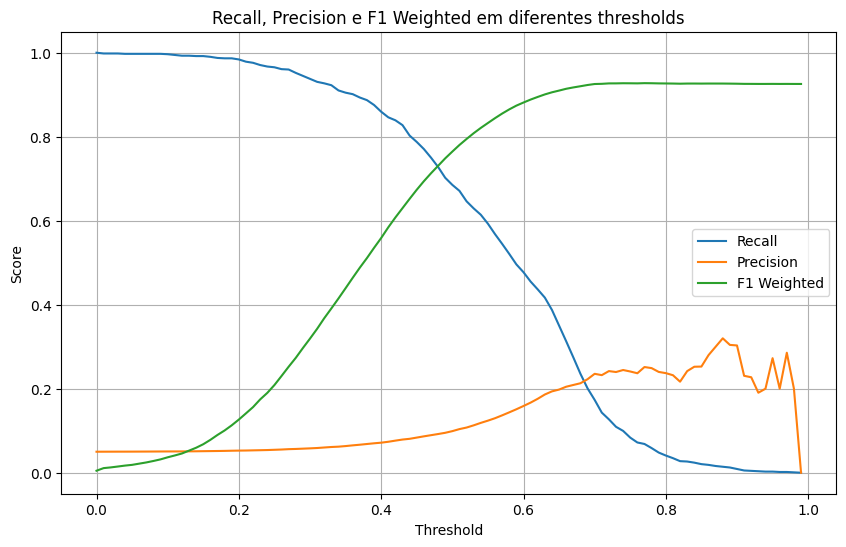

In [49]:
# Criando o dicionário base
data_dict = {"Threshold":[], 
             "Recall":[],
             "Precision":[],
             "F1 Weighted":[],
             "Ganhos Brutos":[],
             "Perdas":[],
             "Ganhos Líquidos":[]}

# Adicionando as predições de probabilidade
data_metrics["score_fraude_logistica_2"] = pipe_logistica_2.predict_proba(x_teste)[:, 1]

# Calculando as métricas para cada threshold
for threshold in np.arange(0, 1, 0.01):
    predictions = (data_metrics["score_fraude_logistica_2"] >= threshold).astype(int)
    recall = recall_score(y_teste, predictions)
    precision = precision_score(y_teste, predictions)
    f1 = f1_score(y_teste, predictions, average="weighted")
    data_dict["Threshold"].append(threshold)
    data_dict["Recall"].append(recall)
    data_dict["Precision"].append(precision)
    data_dict["F1 Weighted"].append(f1)
    
    data_metrics["label_fraude_novo_logistica_2"] = predictions
    acertos = data_metrics.query(f"fraude == 0 and label_fraude_novo_logistica_2 == 0")
    erros = data_metrics.query(f"fraude == 1 and label_fraude_novo_logistica_2 == 0")
    ganhos = (acertos["valor_compra"] * 0.10).sum()
    perdas = erros["valor_compra"].sum()
    diff_ganhos_perdas = ganhos - perdas
    data_dict["Ganhos Brutos"].append(ganhos)
    data_dict["Perdas"].append(perdas)
    data_dict["Ganhos Líquidos"].append(diff_ganhos_perdas)
        
# Plotando o gráfico    
plt.figure(figsize=(10, 6))
sns.lineplot(x=data_dict["Threshold"], y=data_dict["Recall"], label='Recall')
sns.lineplot(x=data_dict["Threshold"], y=data_dict["Precision"], label='Precision')
sns.lineplot(x=data_dict["Threshold"], y=data_dict["F1 Weighted"], label='F1 Weighted')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision e F1 Weighted em diferentes thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Visualizando os dados em forma de tabela
pd.DataFrame(data_dict).sort_values(by="Ganhos Líquidos", ascending=False)

,Threshold,Recall,Precision,F1 Weighted,Ganhos Brutos,Perdas,Ganhos Líquidos
63,0.63,0.416889,0.186259,0.900738,65839.970,24752.43,41087.540
64,0.64,0.387556,0.193692,0.905765,67241.512,26356.77,40884.742
62,0.62,0.436444,0.176049,0.894750,64303.221,23646.66,40656.561
65,0.65,0.350222,0.197990,0.909869,68548.797,28405.18,40143.617
61,0.61,0.455111,0.166938,0.888463,62788.854,22742.20,40046.654
...,...,...,...,...,...,...,...
4,0.04,0.997333,0.050181,0.016964,767.363,205.50,561.863
3,0.03,0.998222,0.050168,0.014767,681.170,133.68,547.490
2,0.02,0.998222,0.050114,0.012649,605.596,133.68,471.916
1,0.01,0.998222,0.050071,0.010969,575.519,133.68,441.839


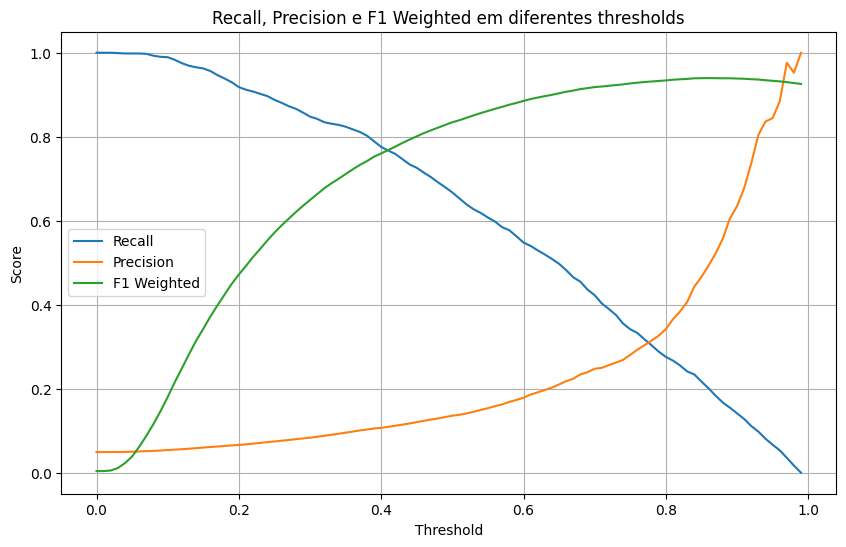

In [51]:
# Criando o dicionário base
data_dict = {"Threshold":[], 
             "Recall":[],
             "Precision":[],
             "F1 Weighted":[],
             "Ganhos Brutos":[],
             "Perdas":[],
             "Ganhos Líquidos":[]}

# Adicionando as predições de probabilidade
data_metrics["score_fraude_lightgbm"] = pipelgbm.predict_proba(x_teste)[:, 1]

# Calculando as métricas para cada threshold
for threshold in np.arange(0, 1, 0.01):
    predictions = (data_metrics["score_fraude_lightgbm"] >= threshold).astype(int)
    recall = recall_score(y_teste, predictions)
    precision = precision_score(y_teste, predictions)
    f1 = f1_score(y_teste, predictions, average="weighted")
    data_dict["Threshold"].append(threshold)
    data_dict["Recall"].append(recall)
    data_dict["Precision"].append(precision)
    data_dict["F1 Weighted"].append(f1)
    
    data_metrics["label_fraude_novo_lightgbm"] = predictions
    acertos = data_metrics.query(f"fraude == 0 and label_fraude_novo_lightgbm == 0")
    erros = data_metrics.query(f"fraude == 1 and label_fraude_novo_lightgbm == 0")
    ganhos = (acertos["valor_compra"] * 0.10).sum()
    perdas = erros["valor_compra"].sum()
    diff_ganhos_perdas = ganhos - perdas
    data_dict["Ganhos Brutos"].append(ganhos)
    data_dict["Perdas"].append(perdas)
    data_dict["Ganhos Líquidos"].append(diff_ganhos_perdas)
        
# Plotando o gráfico    
plt.figure(figsize=(10, 6))
sns.lineplot(x=data_dict["Threshold"], y=data_dict["Recall"], label='Recall')
sns.lineplot(x=data_dict["Threshold"], y=data_dict["Precision"], label='Precision')
sns.lineplot(x=data_dict["Threshold"], y=data_dict["F1 Weighted"], label='F1 Weighted')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision e F1 Weighted em diferentes thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Visualizando os dados em forma de tabela
pd.DataFrame(data_dict).sort_values(by="Ganhos Líquidos", ascending=False)

,Threshold,Recall,Precision,F1 Weighted,Ganhos Brutos,Perdas,Ganhos Líquidos
66,0.66,0.482667,0.218687,0.907167,73055.772,22947.13,50108.642
65,0.65,0.497778,0.210923,0.903510,72069.916,22254.39,49815.526
64,0.64,0.509333,0.203480,0.899870,71137.272,21817.31,49319.962
63,0.63,0.520000,0.197836,0.896723,70468.030,21317.86,49150.170
67,0.67,0.465778,0.224507,0.910012,73881.385,24914.57,48966.815
...,...,...,...,...,...,...,...
4,0.04,0.998222,0.050397,0.023717,272.429,8.11,264.319
3,0.03,0.999111,0.050141,0.012035,89.163,6.20,82.963
2,0.02,1.000000,0.050036,0.006186,14.535,0.00,14.535
1,0.01,1.000000,0.050000,0.004762,0.000,0.00,0.000


Agora que temos nossas soluções no máximo de polimento, vamos verificar a taxa
de fraude gerada por cada uma das soluções, incluindo o modelo antigo.
 
Para esse cálculo, vamos usar a seguinte fórmula:<br><br>
$\text{Taxa de Fraude} = \frac{\text{Quantidade Falsos Negativos}}{\text{Total de registros}}$

In [59]:
# Salvando as labels no melhor threshold de cada solução
data_metrics["label_fraude_modelo"] = (data_metrics["score_fraude_modelo"] >= 0.76).astype(int)
data_metrics["label_fraude_novo_logistica_2"] = (data_metrics["score_fraude_modelo"] >= 0.63).astype(int)
data_metrics["label_fraude_novo_lightgbm"] = (data_metrics["score_fraude_modelo"] >= 0.66).astype(int)

# Salvando as taxas em variáveis
tx_modelo_antigo = (data_metrics.query("fraude == 1 and label_fraude_modelo == 0").shape[0] / data_metrics.shape[0]) * 100
tx_logistica = (data_metrics.query("fraude == 1 and label_fraude_novo_logistica_2 == 0").shape[0] / data_metrics.shape[0]) * 100
tx_lightgbm = (data_metrics.query("fraude == 1 and label_fraude_novo_lightgbm == 0").shape[0] / data_metrics.shape[0]) * 100

print("Modelo antigo: ", round(tx_modelo_antigo, 2))
print("Logística: ", round(tx_logistica, 2))
print("LightGBM: ", round(tx_lightgbm, 2))

Modelo antigo:  1.8
Logística:  1.34
LightGBM:  1.38


Para melhor entendimento, vamos resumir os achados em uma tabela e avaliar a 
melhor solução:

|               | Melhor Threshold | Melhor Recall | Melhor F1 | Latência Média (ms) | Ganho Bruto |  Perdas  | Ganho Líquido | Taxa de Fraude |
|:-------------:|:----------------:|:-------------:|:---------:|:-------------------:|:-----------:|:--------:|:-------------:|:--------------:|
| Modelo Antigo |       0.76       |      0.64     |    0.84   |          -          |   65912.19  | 19549.98 |    46362.21   |       1.8      |
|  Logística_v2 |       0.63       |      0.41     |    0.90   |          20         |   65839.97  | 24752.43 |    41087.54   |      1.34      |
|    LightGBM   |       0.66       |      0.48     |    0.90   |          39         |   73055.77  | 22947.13 |    50108.64   |      1.38      |

Vamos levantar alguns pontos:
- O modelo antigo se mostrou superior as novas soluções em evitar falsos negativos, ou seja, ele é superior em identificar transações que são fraudulentas de verdade.
- Por outro lado, o modelo já implantado também bloqueia com mais frequência compras que são verídicas, impedindo que mais dinheiro entre no negócio.
- A latência do LightGBM é quase o dobro da R. Logística.
- A R. Logística, mesmo com ajuste de threshold, não consegue bater os ganhos do modelo antigo.
- Ambos os modelos treinados reduziriam a taxa de fraude registrada.
- O lucro registrado no LightGBM é 8% maior do que o do modelo antigo.

Dado o que foi exposto aqui, selecionaremos o **LightGBM** para ser implantado.
   

In [2]:
((50108.64*100)/46362.21) - 100 

8.080783897057543

In [19]:
joblib.dump(pipe, "../models/logistica.pkl")

['../models/logistica.pkl']